# Case Study: ISLAS flight IS22-07, 29th. March 2022



In [1]:
# imports from packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # gridspec for nested subfigures
import matplotlib.dates as mdates
from matplotlib.lines import Line2D  # for legend handle
#import seaborn as sns
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from datetime import datetime

# imports from files
import functions
import read_cdp
import read_cip_txt
#import read_lwc
import read_nav
import read_cip_nc
import plots
import numb_conc
import read_seaice
#import in_cloud_detect
#from data_intake import read_sic
#from plots import plots.letter_annotation
from plots import plot_map

# surpress UserWarning connected to timezoneless np.datetime
warnings.filterwarnings("ignore", message="no explicit representation of timezones available for np.datetime64")
# surpress UserWrning connected to boolean series indexing (creating dataframe with null values)
warnings.filterwarnings("ignore", message="Boolean Series key will be reindexed to match DataFrame index.")

In [2]:
# --- Global formatting/settings/variables



# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')

# colors for flights (to use all the same colors!
c_flights = {'IS22-01':'wheat',
              'IS22-02':'tab:green',
              'IS22-03':'tab:red',
              'IS22-04':'tab:purple',
              'IS22-05':'tab:blue',
              'IS22-06':'tab:brown',
              'IS22-07':'tab:gray',
              'IS22-08':'tab:olive',
              'IS22-09':'tab:cyan',
              'IS22-10':'tab:pink',
              'IS22-11':'tab:orange'}

# Threshold for in-cloud values
# following the korolev 22 paper: "In the present study the thresholds for liquid water content and ice water content (IWC) 
# were set as LWC > 0.01 g m−3, IWC > 0.01 g m−3, respectively. The phase composition of clouds was identified based on the 
# assessment of the ice water fraction mu = IWC∕(LWC + IWC). Thus, clouds with mu=0.9 were considered as ice, 
# clouds with Mu =0.1 were defined as liquid, 
# and clouds 0.1 ≤ 𝜇𝜇 ≤ 0.9 were determined as mixed-phase clouds."
lwc_th = 0.01

In [3]:
# --- Data import
# Based on scripts in files read_*.py

# Navigational data (nav_df: data variables, nav_stats_dict: statistics for each flight)
nav_df, nav_stats_dict, extra_info= read_nav.read_nav() # extra infor includes limits for the plots and extra landing and takeoff times

# CDP data (cdp_bulk_df: Bulk variables per flight, cdp_bins_df: Bin details (max, min size)
#           cdp_var_df: Variable information (names, units), cdp_meta_df: Metadata/instrument settings)
cdp_bulk_df, cdp_bins_df, cdp_var_df, cdp_meta_df = read_cdp.read_cdp(nav_df)

# CIP data 
# nc file(bulk information) (cip_bulk_calc_df: Bulk variables per flight, cip_conc_df: Concentration per bin, 
#                            cip_varnc_df: Variable, longname and unit)
cip_bulk_calc_df, cip_conc_df, cip_varnc_df = read_cip_nc.read_cip_nc() 
cip_pb_df, cip_bins_df, cip_var_df, cip_proc_df = read_cip_txt.read_cip_txt()



----Reading CDP files:
Reading: ../2022-islas/as220014/microphy/pads/20220403071511/02CDP 20220403071511.csv
Reading: ../2022-islas/as220009/microphy/pads/20220326080106/02CDP 20220326080106.csv
Reading: ../2022-islas/as220010/microphy/pads/02CDP 20220326133751.csv
Reading: ../2022-islas/as220007/microphy/pads/20220324080247/02CDP 20220322105458.csv
Reading: ../2022-islas/as220015/microphy/pads/20220403123534/02CDP 20220403123534.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324080247/02CDP 20220324080247.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324113123/02CDP 20220324113123.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324130909/02CDP 20220324130909.csv
Reading: ../2022-islas/as220013/microphy/pads/20220331093304/02CDP 20220331093304.csv
Reading: ../2022-islas/as220011/microphy/pads/02CDP 20220329081432.csv
Reading: ../2022-islas/as220012/microphy/pads/20220330135853/02CDP 20220330135853.csv
Reading: ../2022-islas/as220012/microphy/pads/20220330134834/

In [4]:
# Temp testing for sampling errors
# times to look at:
t1 = '2022-03-24 13:50:00'
t2 = '2022-03-24 13:50:30'
case_cip_df = cip_bulk_calc_df[(cip_bulk_calc_df['time']>=t1)&(cip_bulk_calc_df['time']<=t2)]
case_cdp_df = cdp_bulk_df[(cdp_bulk_df['time']>=t1)&(cdp_bulk_df['time']<=t2)][['time','LWC (g/m^3)','LWC corr (g/m^3)']] # only take some of the columns
#case_cdp_df
case_cip_df

,time,UTC Seconds,TAS (m/s),MVD (um),LWC (gram/m3),NT (#/m3),MND (um),Area Ratio (1/m),IWC (gram/m3),safireid
Time,,,,,,,,,,
4147,2022-03-24 13:50:00,49800.0,96.0,578.009460,0.929513,22790.833984,349.357147,0.001450,0.135726,as220008
4148,2022-03-24 13:50:05,49805.0,98.0,521.523987,0.849598,23464.486328,343.624176,0.001426,0.133113,as220008
4149,2022-03-24 13:50:10,49810.0,95.0,649.863281,1.153160,24260.753906,352.595673,0.001718,0.151867,as220008
4150,2022-03-24 13:50:15,49815.0,99.0,1041.431763,2.120311,25800.066406,372.460693,0.002504,0.203122,as220008
4151,2022-03-24 13:50:20,49820.0,100.0,1242.238770,2.347719,14996.417969,454.412079,0.002342,0.179724,as220008
4152,2022-03-24 13:50:25,49825.0,99.0,1184.599487,1.676648,9583.533203,498.236755,0.001730,0.130868,as220008
4153,2022-03-24 13:50:30,49830.0,100.0,1114.854004,1.340062,7009.793945,554.935242,0.001400,0.107806,as220008


In [5]:
# -- Prepare dataframe for calculations
# Join the relevant columns from the nav, the cip, and the cdp data
# CIP IWC, LWC etc have been calculated for particles >100 mum
cip_df = cip_bulk_calc_df[['time', 'NT (#/m3)','IWC (gram/m3)','LWC (gram/m3)', 'MVD (um)']].sort_values(by='time', axis=0)
cdp_df = cdp_bulk_df[['time', 'Number Conc corr (#/cm^3)', 'LWC corr (g/m^3)','MVD (um)','Number Conc (#/cm^3)', 'LWC (g/m^3)']].sort_values(by='time', axis=0)

# rename columns to identify instrument and standardize units
cip_df = cip_df.rename(columns={'NT (#/m3)':'cip NumConc (#/m^3)','IWC (gram/m3)':'cip IWC (g/m^3)','LWC (gram/m3)':'cip LWC (g/m^3)', 'MVD (um)':'cip MVD (um)'})
cdp_df = cdp_df.rename(columns={'Number Conc corr (#/cm^3)': 'cdp NumConc corr (#/cm^3)', 'LWC corr (g/m^3)':'cdp LWC corr (g/m^3)',
                                'MVD (um)': 'cdp MVD (um)','Number Conc (#/cm^3)': 'cdp NumConc (#/cm^3)', 'LWC (g/m^3)':'cdp LWC (g/m^3)'})

# select temperature and flightid from nav
nav_sel_df = nav_df[['Latitude (degree)', 'Longitude (degree)','Altitude (meter)','Temperature (Celsius)','TAS (m/s)','flightid', 'safireid']].sort_values(by='time', axis=0)

# join cip and cdp by time
meas_df = pd.merge_asof(cip_df, cdp_df, on = 'time', direction = 'nearest', suffixes=('_cip','_cdp'))
microphy_df = pd.merge_asof(meas_df, nav_sel_df, on = 'time', direction = 'nearest')

# add manually set selection categories
microphy_df = functions.add_man_relevance(microphy_df) # relevant clouds: lower mixed phase
microphy_df = functions.add_man_cloud(microphy_df)     # cloudid: individual flight patterns from single flights

# prepare dataframe for later calculation of position in cloud and surface conditions:
microphy_df['Cloud_pos']=np.nan # empty column to be filled with cloud positions
microphy_df['Cloud_rel_alt']=np.nan # empty column to be filled with cloud relative altitude (0 = base 1 = top)
microphy_df['surface_cond']='sea-ocean' # set default to sea-ocean

# rearrange columns more logically: - Positional - Identifier - Ambient - Microphysical - Calculated
microphy_df = microphy_df[['time','Latitude (degree)','Longitude (degree)','Altitude (meter)',
                          'flightid', 'safireid',
                          'Temperature (Celsius)','TAS (m/s)',
                           'cip NumConc (#/m^3)','cdp NumConc (#/cm^3)','cdp NumConc corr (#/cm^3)',
                           'cip IWC (g/m^3)','cip LWC (g/m^3)','cdp LWC (g/m^3)','cdp LWC corr (g/m^3)',
                           'cip MVD (um)','cdp MVD (um)',
                           'Relevance','cloudid','Cloud_pos', 'Cloud_rel_alt', 'surface_cond']]


In [6]:
# -- Get sea_ice concentration along flight tracks from satellite data
# Sea ice concentration
seaice_df = read_seaice.read_seaice(microphy_df, extra_info)

# merge with microphy
microphy_df = pd.merge(microphy_df, seaice_df, on=['time','Latitude (degree)','Longitude (degree)','flightid'], how='inner')

# update surface_cond to 'sea-ice' if 'Sea Ice Conc. (Percent)' > 15 %
#microphy_df.loc[microphy_df["Sea Ice Conc. (Percent)"] >15, "surface_cond"] = 'sea-ice'

# ALTERNATIVE: Update surface cond for 'sea-ice' and marginal ice zone: 'MIZ'
# following Young et. al. MIZ for sea ice fraction between 10% and 90%
microphy_df.loc[microphy_df["Sea Ice Conc. (Percent)"] >90, "surface_cond"] = 'sea-ice'
microphy_df.loc[(microphy_df["Sea Ice Conc. (Percent)"] >10) & (microphy_df["Sea Ice Conc. (Percent)"] <=90), "surface_cond"] = 'MIZ'



----Reading sea-ice files
Flight: IS22-02, date: 20220322
Flight: IS22-03, date: 20220324
Flight: IS22-04, date: 20220324
Flight: IS22-05, date: 20220326
Flight: IS22-06, date: 20220326
Flight: IS22-07, date: 20220329
Flight: IS22-08, date: 20220330
Flight: IS22-09, date: 20220331
Flight: IS22-10, date: 20220403
Flight: IS22-11, date: 20220403


In [7]:
microphy_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cip MVD (um)',
       'cdp MVD (um)', 'Relevance', 'cloudid', 'Cloud_pos', 'Cloud_rel_alt',
       'surface_cond', 'Sea Ice Conc. (Percent)'],
      dtype='object')

In [8]:
# -- Update surface_cond with land mask

def update_land(row):
    # Function to use globe_land_mask to check each lat, lon pair if land.
    # Returns the original value of 'surface_cond' if not land and 'land' if land

    # import package
    from global_land_mask import globe
    
    if globe.is_land(row['Latitude (degree)'], row['Longitude (degree)']):
        return 'land'
    return row['surface_cond']

# Apply the function to each row
microphy_df['surface_cond'] = microphy_df.apply(update_land, axis=1)

In [9]:
# --- Preparations for binned information (size distributions)

# Add islasids to the binned dataframes
cip_pb_df = functions.safireid_to_islasid(cip_pb_df, extra_info['ext_landing'])
cdp_bulk_df = functions.safireid_to_islasid(cdp_bulk_df, extra_info['ext_landing'])

In [10]:
# --- calculated parameters

# Total number concentration (adding CIP and CDP)
microphy_df['cip NumConc (#/cm^3)'] = microphy_df['cip NumConc (#/m^3)']*10**(-6) # adjust cip to equal units as cdp
# sum cip and cdp in #/cm3 to find total num conc
microphy_df['tot NumConc (#/cm3)'] = microphy_df['cip NumConc (#/cm^3)']+microphy_df['cdp NumConc corr (#/cm^3)']

# TWC - Total Water Content: estimate total water content from cdp LWC and CIP IWC 
microphy_df['TWC (gram/m3)'] = microphy_df['cdp LWC corr (g/m^3)'] + microphy_df['cip IWC (g/m^3)']

# Selection of in-cloud values (True or False based on threshold condition)
in_cl_th = 0.01 # in-cloud threshold based on Korolev 2003
microphy_df['incloud']= microphy_df['TWC (gram/m3)']>in_cl_th #direct boolean indexing (True if bigger, False if smaller)

# -- incloud height calculations
# calculating in-cloud altitude dictionary for all named clouds:
cloud_alt_dict = functions.cloud_alt_pos(microphy_df, 'cloudid') # get the cloud top and base heights (in a dict)

# Calculating in-cloud relative altitude based on max and min altitude of cloud
cloudids = microphy_df[microphy_df['cloudid']!='nan']['cloudid'].unique() # get unique cloudids
microphy_df['Cloud_rel_alt']=microphy_df.apply(functions.rel_alt, args=(cloudids, cloud_alt_dict), axis=1)

# set category "Top-Bulk-Base", categorize data based on where in cloud:
# Apply the function row-wise to create the new column
microphy_df['Cloud_pos'] = microphy_df.apply(functions.set_c_pos_cat, cloud_pos_dict = cloud_alt_dict, axis=1)

## Issues with preparing for making the number concentation plots that needs to be adressed:
Want to: add surface information and where in cloud information to the two binned dfs. 

### differences in timesteps between datasets
- Microphy_df: 5 s
- cip_pb_df: 5 s 
- cip_bulk_df: 1 s 

### Data issues (TODO/CHECK)
- Check why no cip_pd_df data from IS22-04, cip_df has IS22-04 data:
  
cip_pb_df[(cip_pb_df['time']<'2022-03-25')&(cip_pb_df['time']>'2022-03-23')] only IS22-03 data
cip_df[(cip_df['time']<'2022-03-25')&(cip_df['time']>'2022-03-23')] gives also IS22-04 data

In [11]:
# --- adding categorizing columns to the dfs needed for size distribution calculations
# ---- Testing: single flights
# checking different times and columns for the same flight for the three main dfs
#flight = 'IS22-10' #first sea-ice flight

# get only the data from the flight for each of the dfs
#t_microphy_df = microphy_df[microphy_df['flightid']==flight]
#t_cip_pb_df = cip_pb_df[cip_pb_df['flightid']==flight]
#t_cdp_bulk_df = cdp_bulk_df[cdp_bulk_df['flightid']==flight]

# Find the columns from microphy you wish to join with cip_pb_df & cdp_bulk_df:
# columns to add: 'surface_cond', 'cloudid', 'Cloud_pos'
# joint columns: 'time' (alt.'flightid', 'safireid')
# microphy_df.columns # to see all columns

# Join certain colums from microphy to cdp_pb on time
# TODO: double check how the cdp is combined!! microphy_df is in 5 sek intervals, cdp_bulk_df is in 1 sk intervals. 
# Be sure of what nearest means in this context.
#t_cip_pb_df = pd.merge_asof(t_cip_pb_df, microphy_df[['time','surface_cond', 'cloudid','Cloud_pos', 'incloud','Relevance']], on = 'time', direction = 'nearest')
#t_cdp_bulk_df = pd.merge_asof(t_cdp_bulk_df, microphy_df[['time','surface_cond', 'cloudid','Cloud_pos', 'incloud','Relevance']], on = 'time', direction = 'nearest')

In [12]:
# --- adding categorizing columns to the dfs needed for size distribution calculations
# ---- Testing: full dataset

# Find the columns from microphy you wish to join with cip_pb_df & cdp_bulk_df:
# columns to add: 'surface_cond', 'cloudid', 'Cloud_pos'
# joint columns: 'time' (alt.'flightid', 'safireid')
# microphy_df.columns # to see all columns

# need to sort the dfs on time before joining
cip_pb_df = cip_pb_df.sort_values(by='time')
cdp_bulk_df = cdp_bulk_df.sort_values(by='time')

# Join certain colums from microphy to cdp_pb on time
# TODO: double check how the cdp is combined!! microphy_df is in 5 sek intervals, cdp_bulk_df is in 1 sk intervals. 
# Be sure of what nearest means in this context.

cip_pb_df = pd.merge_asof(cip_pb_df, microphy_df[['time','surface_cond', 'cloudid','Cloud_pos', 'incloud','Relevance']], on = 'time', direction = 'nearest')
cdp_bulk_df = pd.merge_asof(cdp_bulk_df, microphy_df[['time','surface_cond', 'cloudid','Cloud_pos', 'incloud','Relevance']], on = 'time', direction = 'nearest')

cip_pb_df.head()

,UTC Seconds,Nt,IWC,MMD,Conc001,Conc002,Conc003,Conc004,Conc005,Conc006,...,Conc063,Conc064,safireid,time,flightid,surface_cond,cloudid,Cloud_pos,incloud,Relevance
0,41841.0,1180.0,0.001790,199.0,208000000.0,21100000.0,0.0,10900000.0,7120000.0,12600000.0,...,0.0,0.0,as220007,2022-03-22 11:37:21,IS22-02,land,nan,None,False,Upper clouds
1,41846.0,455.0,0.000519,169.0,162000000.0,16400000.0,7430000.0,8500000.0,12400000.0,977000.0,...,0.0,0.0,as220007,2022-03-22 11:37:26,IS22-02,land,nan,None,False,Upper clouds
2,41851.0,674.0,0.001100,213.0,0.0,0.0,0.0,6430000.0,6980000.0,4930000.0,...,0.0,0.0,as220007,2022-03-22 11:37:31,IS22-02,land,nan,None,False,Upper clouds
3,41856.0,531.0,0.000675,193.0,0.0,0.0,4620000.0,2640000.0,8600000.0,2430000.0,...,0.0,0.0,as220007,2022-03-22 11:37:36,IS22-02,land,nan,None,False,Upper clouds
4,41861.0,722.0,0.001080,208.0,97000000.0,8220000.0,3710000.0,2120000.0,11100000.0,977000.0,...,0.0,0.0,as220007,2022-03-22 11:37:41,IS22-02,land,nan,None,False,Upper clouds


### Testing resampled cdp_data

In [13]:
microphy_df.columns
# select the interesting area for testing
case_microphy_df = microphy_df[(microphy_df['time']>=t1) & (microphy_df['time']<=t2)][['time','cdp LWC corr (g/m^3)','cip IWC (g/m^3)']]
case_microphy_df

,time,cdp LWC corr (g/m^3),cip IWC (g/m^3)
6505,2022-03-24 13:50:00,3.862500e-06,0.135726
6506,2022-03-24 13:50:05,3.629957e-07,0.133113
6507,2022-03-24 13:50:10,2.078089e-03,0.151867
6508,2022-03-24 13:50:15,6.011585e-02,0.203122
6509,2022-03-24 13:50:20,5.166535e-02,0.179724
6510,2022-03-24 13:50:25,2.204860e-01,0.130868
6511,2022-03-24 13:50:30,3.068937e-01,0.107806


In [14]:
# Test with resampled cdp data
import xarray as xr
cdp_file = '../Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-04.nc'
cdp_ds = xr.open_dataset(cdp_file)
lwc_da = cdp_ds['LWC corr'].resample(time='5s').mean() # resample

#cdp_ds
case_lwc_da = lwc_da.sel(time=slice(t1,t2))
case_lwc_da

<xarray.DataArray 'LWC corr' (time: 7)> Size: 56B
array([6.98877436e-07, 1.58134183e-03, 1.24166688e-02, 5.46179295e-02,
       1.77720003e-01, 2.83267444e-01, 2.97929113e-01])
Coordinates:
  * time     (time) datetime64[ns] 56B 2022-03-24T13:50:00 ... 2022-03-24T13:...
Attributes:
    name:              Liquid water content TAS corrected
    unit:              g/m^3
    description:       Liquid water content corrected with the TAS correction...
    parent variables:  ['LWC', 'TAS correction factor']

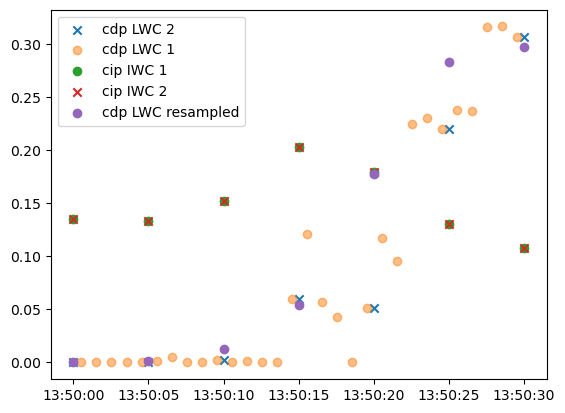

In [15]:
fig, ax = plt.subplots()

ax.scatter(case_microphy_df['time'], case_microphy_df['cdp LWC corr (g/m^3)'], marker = 'x',label='cdp LWC 2')
ax.scatter(case_cdp_df['time'], case_cdp_df['LWC corr (g/m^3)'], label='cdp LWC 1', alpha=0.5)
ax.scatter(case_cip_df['time'], case_cip_df['IWC (gram/m3)'], label = 'cip IWC 1')
ax.scatter(case_microphy_df['time'], case_microphy_df['cip IWC (g/m^3)'], marker='x', label='cip IWC 2')
ax.scatter(case_lwc_da['time'], case_lwc_da, marker = 'o', label='cdp LWC resampled')

plt.legend()
plt.show()

In [16]:
# change microphy_ds to only the IS22-04 data and change the LWC corrected to the resampled cdp data
microphy_df = microphy_df[microphy_df['flightid']=='IS22-04']
print(len(microphy_df))
test = lwc_da.to_pandas()
microphy_df = microphy_df.join(test, on='time', how='left') # join the resampled cdp data

3367


In [17]:
# drop the original LWC and rename the resampled one for testing
microphy_df = microphy_df.drop('cdp LWC corr (g/m^3)', axis=1) 
microphy_df = microphy_df.rename(columns={'LWC corr':'cdp LWC corr (g/m^3)'}) 


In [18]:
# -- Calculate SLF (supercooled liquid fraction)
# estimate total water content from cdp as liquid and all from CIP as ice (use LWC from cdp and IWC from CIP)
microphy_df['TWC (gram/m3)'] = microphy_df['cdp LWC corr (g/m^3)']+microphy_df['cip IWC (g/m^3)']

# masking all values of TWC lower than in cloud threshold
microphy_df['TWC (gram/m3)'] = microphy_df['TWC (gram/m3)'].mask(microphy_df['TWC (gram/m3)'] < lwc_th)

# also mask cloud parameters for same time step
microphy_df['cdp LWC corr (g/m^3)'] = microphy_df['cdp LWC corr (g/m^3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))
microphy_df['cip IWC (g/m^3)'] = microphy_df['cip IWC (g/m^3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))
microphy_df['tot NumConc (#/cm3)'] = microphy_df['tot NumConc (#/cm3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))

# calculate SLF by dividing LWC with TWC
microphy_df['SLF']= microphy_df['cdp LWC corr (g/m^3)']/microphy_df['TWC (gram/m3)']*100

# categorize cloud phase
# set up categories for phase determination
# list of conditions to select categories
SLF_conds = [
    (microphy_df['SLF'] <= 0.1),
    (microphy_df['SLF'] >= 0.9),
    (microphy_df['SLF'] > 0.1) & (microphy_df['SLF'] < 0.9)
]
# list of categories to return
phase = [
    'ice',
    'liquid',
    'mixed-phase'
]
microphy_df['cloud_phase']=np.select(SLF_conds,phase,"Outside of cloud")

In [19]:
microphy_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cip MVD (um)', 'cdp MVD (um)', 'Relevance',
       'cloudid', 'Cloud_pos', 'Cloud_rel_alt', 'surface_cond',
       'Sea Ice Conc. (Percent)', 'cip NumConc (#/cm^3)',
       'tot NumConc (#/cm3)', 'TWC (gram/m3)', 'incloud',
       'cdp LWC corr (g/m^3)', 'SLF', 'cloud_phase'],
      dtype='object')

In [20]:
# Getting overall values of number concentration in-cloud for relevant clouds

# select only in-cloud values:
incloud_df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['Relevance']=='Lower clouds, relevant')]
incloud_ocean_df = incloud_df[incloud_df['surface_cond']=='sea-ocean']
incloud_ice_df = incloud_df[incloud_df['surface_cond']=='sea-ice']

# mean and max total number concentration for all ISLAS clouds, clouds over ocean, clouds over ice
TNC_all_max = max(incloud_df['tot NumConc (#/cm3)'])
TNC_all_mean = np.mean(incloud_df['tot NumConc (#/cm3)'])
TNC_ocean_max = max(incloud_ocean_df['tot NumConc (#/cm3)'])
TNC_ocean_mean = np.mean(incloud_ocean_df['tot NumConc (#/cm3)'])
TNC_ice_max = max(incloud_ice_df['tot NumConc (#/cm3)'])
TNC_ice_mean = np.mean(incloud_ice_df['tot NumConc (#/cm3)'])

# Print out info
print(f'Total number concentration (CDP + CIP)')
print(f'All in-cloud values({len(incloud_df)} values): ')
print(f'max tot NumConc (#/cm3): {TNC_all_max} ')
print(f'mean tot NumConc (#/cm3): {TNC_all_mean} ')
print('---')
print(f'In-cloud values over open ocean({len(incloud_ocean_df)} values): ')
print(f'max tot NumConc (#/cm3): {TNC_ocean_max} ')
print(f'mean tot NumConc (#/cm3): {TNC_ocean_mean} ')
print('---')
print(f'In-cloud values over sea-ice({len(incloud_ice_df)} values): ')
print(f'max tot NumConc (#/cm3): {TNC_ice_max} ')
print(f'mean tot NumConc (#/cm3): {TNC_ice_mean}')

ValueError: max() iterable argument is empty

In [21]:
incloud_ice_df['Sea Ice Conc. (Percent)'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Sea Ice Conc. (Percent), dtype: float64

In [22]:
# -- interesting values for the incloud values of IS22-10 and IS22-11
si_flight_incloud_df = incloud_df[incloud_df['flightid'].isin(['IS22-10','IS22-11'])]

N_drop = si_flight_incloud_df.groupby('surface_cond').agg({'cdp NumConc corr (#/cm^3)': ['mean', 'std', 'max','count']})
print(N_drop)

N_ice = si_flight_incloud_df.groupby('surface_cond').agg({'cip NumConc (#/cm^3)': ['mean', 'std', 'max','count']})
print(N_ice)

LWC = si_flight_incloud_df.groupby('surface_cond').agg({'cdp LWC corr (g/m^3)': ['mean', 'std', 'max','count']})
print(LWC)

IWC = si_flight_incloud_df.groupby('surface_cond').agg({'cip IWC (g/m^3)': ['mean', 'std', 'max','count']})
print(IWC)

Empty DataFrame
Columns: [(cdp NumConc corr (#/cm^3), mean), (cdp NumConc corr (#/cm^3), std), (cdp NumConc corr (#/cm^3), max), (cdp NumConc corr (#/cm^3), count)]
Index: []
Empty DataFrame
Columns: [(cip NumConc (#/cm^3), mean), (cip NumConc (#/cm^3), std), (cip NumConc (#/cm^3), max), (cip NumConc (#/cm^3), count)]
Index: []
Empty DataFrame
Columns: [(cdp LWC corr (g/m^3), mean), (cdp LWC corr (g/m^3), std), (cdp LWC corr (g/m^3), max), (cdp LWC corr (g/m^3), count)]
Index: []
Empty DataFrame
Columns: [(cip IWC (g/m^3), mean), (cip IWC (g/m^3), std), (cip IWC (g/m^3), max), (cip IWC (g/m^3), count)]
Index: []


In [23]:
# --- interesting values per cloudid (grouped by 'cloudid')

# Number concentration
cloud_TotNumbConc = incloud_df.groupby('cloudid').agg({'tot NumConc (#/cm3)': ['mean', 'std', 'max']})
cloud_IceNumbConc = incloud_df.groupby('cloudid').agg({'cip NumConc (#/cm^3)': ['mean', 'std', 'max']})
cloud_DropNumbConc = incloud_df.groupby('cloudid').agg({'cdp NumConc corr (#/cm^3)': ['mean', 'std', 'max']})

# Water content
cloud_TWC = incloud_df.groupby('cloudid').agg({'TWC (gram/m3)': ['mean', 'std', 'max']})
cloud_IWC = incloud_df.groupby('cloudid').agg({'cip IWC (g/m^3)': ['mean', 'std', 'max']})
cloud_LWC = incloud_df.groupby('cloudid').agg({'cdp LWC corr (g/m^3)': ['mean', 'std', 'max']})

# Temperature and altitude
cloud_temps = incloud_df.groupby('cloudid').agg({'Temperature (Celsius)': ['mean', 'min', 'max']})
cloud_alts = incloud_df.groupby('cloudid').agg({'Altitude (meter)': ['mean', 'min', 'max']})

print(cloud_TotNumbConc)

Empty DataFrame
Columns: [(tot NumConc (#/cm3), mean), (tot NumConc (#/cm3), std), (tot NumConc (#/cm3), max)]
Index: []


In [24]:
# --- selecting case study flight
flight = 'IS22-02'
case_df = microphy_df[microphy_df['flightid']==flight]


In [25]:
test = case_df[case_df['SLF']>0]

selected_df = case_df[(case_df['time'] >= '2022-03-24 13:50:00') & (case_df['time'] <= '2022-03-24 14:10:00')]

selected_df
#cdp_df
#cip_df.columns

,time,Latitude (degree),Longitude (degree),Altitude (meter),flightid,safireid,Temperature (Celsius),TAS (m/s),cip NumConc (#/m^3),cdp NumConc (#/cm^3),...,Cloud_rel_alt,surface_cond,Sea Ice Conc. (Percent),cip NumConc (#/cm^3),tot NumConc (#/cm3),TWC (gram/m3),incloud,cdp LWC corr (g/m^3),SLF,cloud_phase


## Plots


IndexError: single positional indexer is out-of-bounds

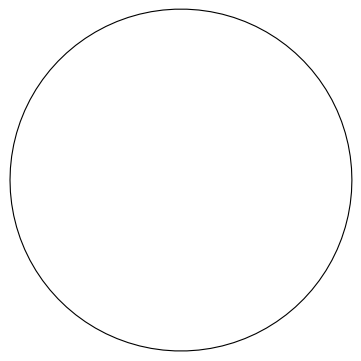

In [26]:
# ---- Plot coordinates -----
#-- Map initialization based on flight info --

# Find the max and min lat and lon in the dataset
inc = 1
lat_max = case_df['Latitude (degree)'].max() + inc
lat_min = case_df['Latitude (degree)'].min() - inc
lon_max = case_df['Longitude (degree)'].max() + inc
lon_min = case_df['Longitude (degree)'].min() - inc

# coordinates of Kiruna
lat_kir = 67.8256
lon_kir = 20.3351

# --- Set up figure
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(1, 3, figure=fig)

ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

fig.suptitle(f'{flight} - {case_df.iloc[0]['time'].date()}') # title for all figure: flightid and date
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=2)
data_projection = ccrs.PlateCarree()

# making a dictionary for setting the colors of the cloudid automatically
c_ids = case_df['cloudid'].unique()
colors = ['lightgrey', 'c', 'm', 'y', 'g','b']
col_dict = dict(zip(c_ids, colors[:len(c_ids)]))
# update first color to use with altitude
colors[0] = 'r'
alt_col_dict = dict(zip(c_ids, colors[:len(c_ids)]))

ax.scatter(case_df['Longitude (degree)'], case_df['Latitude (degree)'], marker='.',c =case_df['cloudid'].map(col_dict), transform = data_projection)


#Plot Kiruna on map
ax.plot(lon_kir, lat_kir, marker='o', color='tab:red', transform=data_projection)
#Add text "Kiruna" at the plotted point
offset_lon = 0.7  # adjust the horizontal offset
offset_lat = -0.7  # adjust the vertical offset
ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.set_title('Flightpath')

ax2 = fig.add_subplot(gs[0,1:])
# plot variable
var = 'TWC (gram/m3)' # variable to show with altitude
#ax2.scatter(case_df['time'], case_df[var], marker = '.',color=np.where(case_df['Relevance']=='Lower clouds, relevant', 'black','silver'))
ax2.scatter(case_df['time'], case_df[var], marker = '.',color=case_df['cloudid'].map(col_dict), alpha=0.3)

ax2.set_ylabel(var)
ax2.set_xlabel('Time')
ax2.set_title('Flight altitude and Total Water Content')

# add second y-axis
ax3 = ax2.twinx()

# Plot altitude of flight (in color green)    
ax3.scatter(case_df['time'], case_df['Altitude (meter)'], marker = '.', color =case_df['cloudid'].map(alt_col_dict), label='Altitude')
ax3.set_ylabel('Altitude (meter)')
ax3.yaxis.label.set_color('r')
ax3.tick_params(axis='y', colors = 'r')
ax2.xaxis.set_major_formatter(formatter) # only show time on x-axis

# Mark cloud position lines 
for cloud in cloudids:
    # get x-endpoint values on axes-coordinates:
    xmin_axes, xmax_axes = functions.get_ax_vals(case_df,'cloudid',cloud, ax2)
    # Set base x-span
    ax3.axhspan(
        ymin=cloud_alt_dict[cloud]['min'],  
        ymax=cloud_alt_dict[cloud]['low_25'],  
        xmin=xmin_axes,
        xmax=xmax_axes,
        color='lightsteelblue',
        alpha=0.3,
        label = 'Base 25% altitude'
    )
    # Set top x-span
    ax3.axhspan(
        ymin=cloud_alt_dict[cloud]['high_25'],  
        ymax=cloud_alt_dict[cloud]['max'],  
        xmin=xmin_axes,
        xmax=xmax_axes,
        color='steelblue',
        alpha=0.3,
        label = 'Top 25% altitude'
    )

# handle management
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # removes duplicate labels
ax3.legend(by_label.values(), by_label.keys(), loc='upper left')

# add a legend
# pop away the first (empty) item
col_dict.pop(next(iter(col_dict)))
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in col_dict.items()]
ax.legend(title='Cloudid', handles=handles, loc='best')

plt.savefig(f'clouds_altitude_{flight}.png')

IndexError: single positional indexer is out-of-bounds

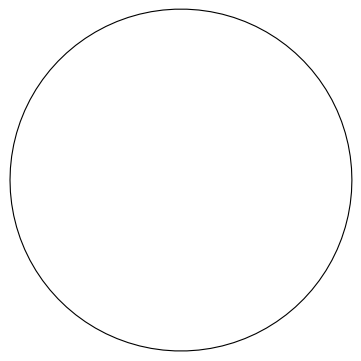

In [27]:
# ---- Plot coordinates -----
#-- Map initialization based on flight info --

# Find the max and min lat and lon in the dataset
inc = 1
lat_max = case_df['Latitude (degree)'].max() + inc
lat_min = case_df['Latitude (degree)'].min() - inc
lon_max = case_df['Longitude (degree)'].max() + inc
lon_min = case_df['Longitude (degree)'].min() - inc

# coordinates of Kiruna
lat_kir = 67.8256
lon_kir = 20.3351

# --- Set up figure
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(1, 3, figure=fig)

ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

fig.suptitle(f'{flight} - {case_df.iloc[0]['time'].date()}') # title for all figure: flightid and date
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=2)
data_projection = ccrs.PlateCarree()

# making a dictionary for setting the colors of the cloudid automatically
c_ids = case_df['cloudid'].unique()
colors = ['lightgrey', 'c', 'm', 'y', 'g','b']
col_dict = dict(zip(c_ids, colors[:len(c_ids)]))
# update first color to use with altitude
colors[0] = 'r'
alt_col_dict = dict(zip(c_ids, colors[:len(c_ids)]))

ax.scatter(case_df['Longitude (degree)'], case_df['Latitude (degree)'], marker='.',c =case_df['cloudid'].map(col_dict), transform = data_projection)


#Plot Kiruna on map
ax.plot(lon_kir, lat_kir, marker='o', color='tab:red', transform=data_projection)
#Add text "Kiruna" at the plotted point
offset_lon = 0.7  # adjust the horizontal offset
offset_lat = -0.7  # adjust the vertical offset
ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.set_title('Flightpath')

ax2 = fig.add_subplot(gs[0,1:])
# plot variable
var = 'TWC (gram/m3)' # variable to show with altitude
#ax2.scatter(case_df['time'], case_df[var], marker = '.',color=np.where(case_df['Relevance']=='Lower clouds, relevant', 'black','silver'))
ax2.scatter(case_df['time'], case_df[var], marker = '.',color=case_df['cloudid'].map(col_dict), alpha=0.3)

ax2.set_ylabel(var)
ax2.set_xlabel('Time')
ax2.set_title('Flight altitude and Total Water Content')

# add second y-axis
ax3 = ax2.twinx()

# Plot altitude of flight (in color green)    
ax3.scatter(case_df['time'], case_df['Altitude (meter)'], marker = '.', color =case_df['cloudid'].map(alt_col_dict), label='Altitude')
ax3.set_ylabel('Altitude (meter)')
ax3.yaxis.label.set_color('r')
ax3.tick_params(axis='y', colors = 'r')
ax2.xaxis.set_major_formatter(formatter) # only show time on x-axis

# Mark cloud position lines 
for cloud in cloudids:
    # get x-endpoint values on axes-coordinates:
    xmin_axes, xmax_axes = functions.get_ax_vals(case_df,'cloudid',cloud, ax2)
    # Set base x-span
    ax3.axhspan(
        ymin=cloud_alt_dict[cloud]['min'],  
        ymax=cloud_alt_dict[cloud]['low_25'],  
        xmin=xmin_axes,
        xmax=xmax_axes,
        color='lightsteelblue',
        alpha=0.3,
        label = 'Base 25% altitude'
    )
    # Set top x-span
    ax3.axhspan(
        ymin=cloud_alt_dict[cloud]['high_25'],  
        ymax=cloud_alt_dict[cloud]['max'],  
        xmin=xmin_axes,
        xmax=xmax_axes,
        color='steelblue',
        alpha=0.3,
        label = 'Top 25% altitude'
    )

# handle management
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # removes duplicate labels
ax3.legend(by_label.values(), by_label.keys(), loc='upper left')

# add a legend
# pop away the first (empty) item
col_dict.pop(next(iter(col_dict)))
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in col_dict.items()]
ax.legend(title='Cloudid', handles=handles, loc='best')

plt.savefig(f'clouds_altitude_{flight}.png')

In [28]:
# zooming in on the interesting parts
#case_sel_df = case_df[(case_df.time >= '2022-03-22 11:45:00') & (case_df.time <= '2022-03-22 14:00:00')] # IS22-02
#case_sel_df = case_df[(case_df.time >= '2022-03-24 10:30:00') & (case_df.time <= '2022-03-24 11:30:00')] # IS22-03
case_sel_df = case_df[(case_df.time >= '2022-03-24 13:30:00') & (case_df.time <= '2022-03-24 14:45:00')] # IS22-04
#case_sel_df = case_df[(case_df.time >= '2022-03-26 09:45:00') & (case_df.time <= '2022-03-26 11:45:00')] # IS22-05
#case_sel_df = case_df[(case_df.time >= '2022-03-26 14:45:00') & (case_df.time <= '2022-03-26 17:00:00')] # IS22-06
#case_sel_df = case_df[(case_df.time >= '2022-03-29 09:55:00') & (case_df.time <= '2022-03-29 11:40:00')] # IS22-07
#case_sel_df = case_df[(case_df.time >= '2022-03-30 15:00:00') & (case_df.time <= '2022-03-30 16:00:00')] # IS22-08
#case_sel_df = case_df[(case_df.time >= '2022-03-31 11:00:00') & (case_df.time <= '2022-03-31 12:45:00')] # IS22-09
#case_sel_df = case_df[(case_df.time >= '2022-04-03 09:05:00') & (case_df.time <= '2022-04-03 10:45:00')] # IS22-10
#case_sel_df = case_df[(case_df.time >= '2022-04-03 12:55:00') & (case_df.time <= '2022-04-03 15:00:00')] # IS22-11

NameError: name 'alt_col_dict' is not defined

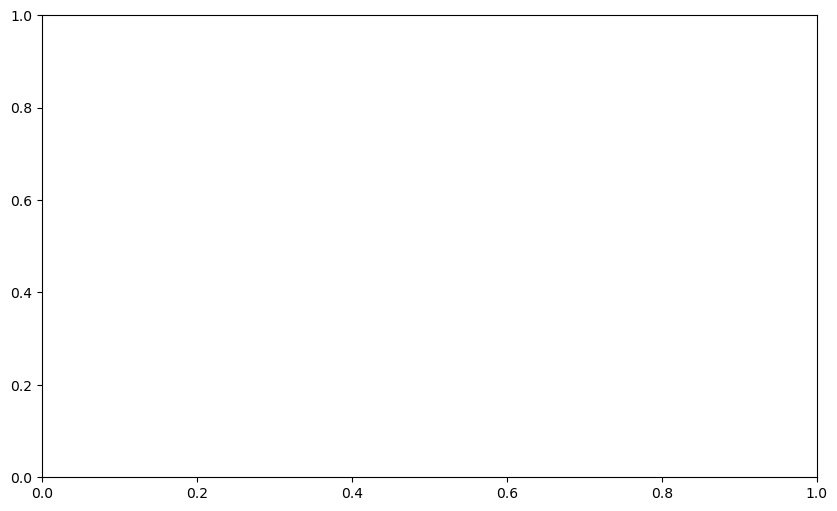

In [29]:
# --- Plotting the heights for testing
# Plotting points where the mean is calculated based on the above selection

var = 'TWC (gram/m3)' # variable to show with altitude
cloudids = case_sel_df[case_sel_df['cloudid']!='nan']['cloudid'].unique() # get unique cloudids, ignoring nan

fig, ax1 = plt.subplots(nrows = 1, ncols=1, figsize=(10,6))

# plot Total Water Content
ax1.scatter(case_sel_df['time'], case_sel_df[var], marker = '.',color =case_sel_df['cloudid'].map(alt_col_dict))
ax1.set_ylabel('TWC (gram/m3)')
ax1.set_xlabel('Time')
ax1.xaxis.set_major_formatter(formatter)
ax1.set_title(f'Closeup, relevant clouds (Flight: {flight})')

#'''
ax2 = ax1.twinx()

# Plot altitude of fligth
ax2.plot(case_sel_df['time'], case_sel_df['Altitude (meter)'], 'r', label='Altitude')
ax2.set_ylabel('Altitude (meter)')
#'''

# Mark cloud position lines 
for cloud in cloudids:
    print(f'skyid: {cloud}')
    # get x-endpoint values on axes-coordinates:
    xmin_axes, xmax_axes = functions.get_ax_vals(case_sel_df,'cloudid',cloud, ax2)
    print(xmin_axes,xmax_axes)
    # Set base x-span
    ax2.axhspan(
        ymin=cloud_alt_dict[cloud]['min'],  
        ymax=cloud_alt_dict[cloud]['low_25'],  
        xmin=xmin_axes,
        xmax=xmax_axes,
        color='lightsteelblue',
        alpha=0.3,
        label = 'Base 25% altitude'
    )
    # Set top x-span
    ax2.axhspan(
        ymin=cloud_alt_dict[cloud]['high_25'],  
        ymax=cloud_alt_dict[cloud]['max'],  
        xmin=xmin_axes,
        xmax=xmax_axes,
        color='steelblue',
        alpha=0.3,
        label = 'Top 25% altitude'
    )

# handle management
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # removes duplicate labels
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

# add a legend for the clouds
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in col_dict.items()]
ax1.legend(title='Cloudid', handles=handles, loc='upper right')

plt.savefig(f'pointsIncloud_{flight}.png')
plt.show()

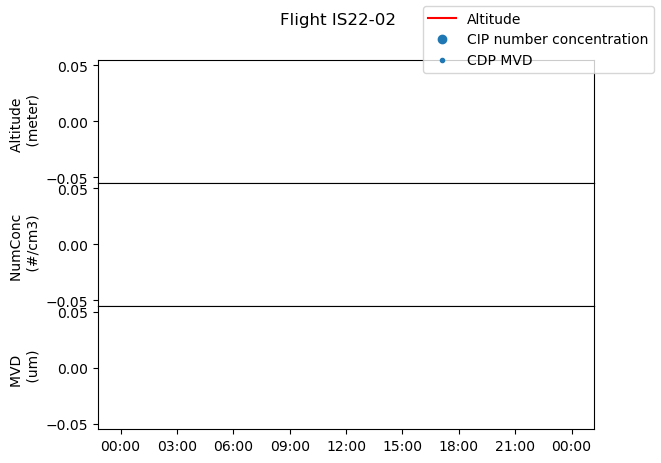

In [30]:
# case_sel_df
# Plot disse i tre høyder.

# Set all 0 to nan for number concentration, and mean volume diameter variables
case_sel_df[case_sel_df['cdp MVD (um)']==0] = np.nan

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle(f'Flight {flight}')
axs[0].plot(case_sel_df['time'], case_sel_df['Altitude (meter)'], 'r', label='Altitude')
axs[0].set_ylabel('Altitude \n (meter)')
#axs[1].plot(case_sel_df['time'],case_sel_df['tot NumConc (#/cm3)'], 'o', label = 'Total number concentration')
axs[1].plot(case_sel_df['time'],case_sel_df['cip NumConc (#/cm^3)'], 'o', label = 'CIP number concentration')
#axs[1].plot(case_sel_df['time'],case_sel_df['cdp NumConc corr (#/cm^3)'], 'o', label = 'CDP number concentration')
axs[1].set_ylabel('NumConc \n (#/cm3)')
#axs[2].plot(case_sel_df['time'], case_sel_df['cip MVD (um)'], '+', label = 'CIP MVD')
axs[2].plot(case_sel_df['time'], case_sel_df['cdp MVD (um)'], '.', label = 'CDP MVD')
axs[2].set_ylabel('MVD \n (um)')

axs[0].set_xlabel('Time')
axs[0].xaxis.set_major_formatter(formatter)

fig.legend()

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [31]:
# testing overview plot for the different parameters

In [32]:
# selecting the times where a value changes
filter1_df = case_sel_df[case_sel_df['cloud_phase']!='Outside of cloud'][['time','Cloud_pos', 'cloudid']] #filter away times where not in cloud
my_column_changes = filter1_df['Cloud_pos'].shift() != filter1_df['Cloud_pos'] #set filter for times there cloud_pos shifts

# Extract rows where my_column_changes is False
cloudpos_in_out_df = filter1_df[my_column_changes]
cloudpos_in_out_df = cloudpos_in_out_df.reset_index(drop=True) # Reset the index 

# Find the last point a cloud is exited: (last entry where cloudid is not equal to a cloudid
last = case_sel_df[(case_sel_df['cloudid']!='nan')].iloc[-1][['time']]

cloudpos_in_out_df['endtime'] = cloudpos_in_out_df['time'] # duplicate time column
cloudpos_in_out_df['endtime'] = cloudpos_in_out_df['endtime'].shift(-1) #shift all times in endtime one row up
cloudpos_in_out_df.iloc[-1, cloudpos_in_out_df.columns.get_loc('endtime')] = last

print(cloudpos_in_out_df)


IndexError: single positional indexer is out-of-bounds

## Marg plot for the full flight and for the mixed phase clouds

In [33]:
microphy_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cip MVD (um)', 'cdp MVD (um)', 'Relevance',
       'cloudid', 'Cloud_pos', 'Cloud_rel_alt', 'surface_cond',
       'Sea Ice Conc. (Percent)', 'cip NumConc (#/cm^3)',
       'tot NumConc (#/cm3)', 'TWC (gram/m3)', 'incloud',
       'cdp LWC corr (g/m^3)', 'SLF', 'cloud_phase'],
      dtype='object')

/home/ninalar/miniconda3/envs/microphy/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:1085: RuntimeWarning: invalid value encountered in divide
  hist /= s
/home/ninalar/miniconda3/envs/microphy/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


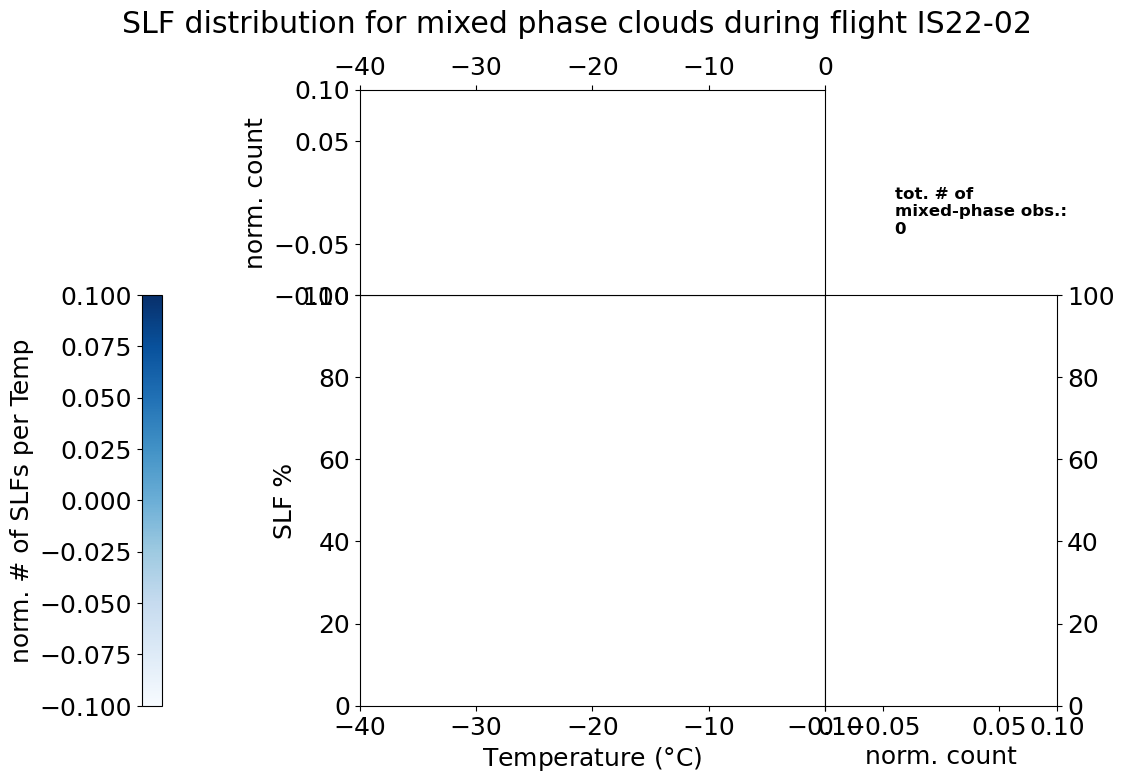

In [34]:
## SINGLE MARGPLOT Testing!!!
def slf_marg_plot(df, title, obs_cat,filestr = ""):
    import matplotlib.gridspec as gridspec

    # preparing for histogram and 2d histogram
    temperature = df['Temperature (Celsius)'].values
    slf = df['SLF'].values

    # Define bins and range
    x_bins = 20
    y_bins = 20
    x_range = [-40, 0]
    y_range = [0, 100]

    # Compute the 2D histogram with numpy histogram2d to get the normalization correct
    hist, xedges, yedges = np.histogram2d(temperature, slf, 
                                       bins=[x_bins, y_bins], 
                                       range=[x_range, y_range], 
                                       density=True)
    
    fig = plt.figure(figsize=(12,8))

    plt.rcParams['font.size'] = 18
    
    gs = gridspec.GridSpec(3, 4, wspace = 0, hspace = 0)
    ax_main = plt.subplot(gs[1:3, 1:3])
    ax_xDist = plt.subplot(gs[0, 1:3],sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 3],sharey=ax_main)
    ax_cb = plt.subplot(gs[1:3,0],sharey=ax_main)
    ax_cb.axis('off')
    ax_text = plt.subplot(gs[0,3])
    ax_text.axis('off')
    plots.letter_annotation(ax_text, 0.3, 0.3, f'tot. # of \n{obs_cat} obs.: \n{len(df)}')
        
    hh = ax_main.imshow(hist.T, origin='lower', cmap=plt.cm.Blues, 
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                     aspect='auto')
    ax_main.set_ylabel('SLF %')
    ax_main.set_xlabel('Temperature ($\mathregular{\degree C}$)')
    
    
    ax_xDist.hist(temperature,bins=x_bins, align='left', density = True) # Density = True means normalized
    ax_xDist.set(ylabel='norm. count')
    ax_xDist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    old_ticks=ax_xDist.get_yticks()
    new_ticks=[x for x in old_ticks if x!=0]
    ax_xDist.set_yticks(new_ticks)
    
    ax_yDist.hist(slf,bins=y_bins,orientation='horizontal', density = True)
    ax_yDist.set(xlabel='norm. count')
    ax_yDist.yaxis.tick_right()
    old_ticks=ax_yDist.get_xticks() # removing 0 from ticks (improves readability)
    new_ticks=[x for x in old_ticks if x!=0]
    ax_yDist.set_xticks(new_ticks)
    
    cbar = plt.colorbar(hh, ax = ax_cb, location='left', orientation='vertical')
    cbar.set_label('norm. # of SLFs per Temp', rotation=90)
    
    fig.suptitle(title, fontsize = 'large')
    plt.show

    if filestr != '':
        plt.savefig(filestr)
    
    return(fig)

df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['Relevance']=='Lower clouds, relevant')]
mp_plot = slf_marg_plot(df, f'SLF distribution for mixed phase clouds during flight {flight}', 'mixed-phase', f'mixedphase{flight}.png')
#all_plot = slf_marg_plot(flight_sel_df, f'SLF for all clouds during flight {flight}', f'allclouds{flight}.png')

In [35]:
# function to create the multifigures.

# Set the default font size for all elements
plt.rcParams.update({'font.size': 10})  # Set this to whatever size you want, e.g., 10


def slf_marg_plot_grid(df, title, row_cat="", col_cat="", filestr=""):
    # Be sure to only use "in-cloud" values from the dataframe:
    df = df[df['incloud']==True]
    
    # Remove NaN values from the row_cat and col_cat columns before getting unique values
    unique_row_cats = df[row_cat].dropna().unique() if row_cat else [""]
    unique_col_cats = df[col_cat].dropna().unique() if col_cat else [""]

    nrows = len(unique_row_cats)
    ncols = len(unique_col_cats)
    fig = plt.figure(figsize=(6 * ncols, 4 * nrows))
    gs = gridspec.GridSpec(6 * nrows, 5 * ncols, figure=fig, wspace=0, hspace=0)
    
    def slf_marg_plot_intern(df, title, i, j):
        ax_main = plt.subplot(gs.new_subplotspec((1 + i * 6, 1 + j * 5), rowspan=2, colspan=2))
        ax_xDist = plt.subplot(gs.new_subplotspec((i * 6, 1 + j * 5), colspan=2), sharex=ax_main)
        ax_yDist = plt.subplot(gs.new_subplotspec((1 + i * 6, 3 + j * 5), rowspan=2), sharey=ax_main)
        ax_cb = plt.subplot(gs.new_subplotspec((1 + i*6, j * 5), rowspan=2), sharey=ax_main)
        ax_cb.axis('off')
        ax_text = plt.subplot(gs.new_subplotspec((i*6, 3+j*5)))
        ax_text.axis('off')

        # Annotate the free area in the right-hand corner with text
        ax_text.annotate(
            f'# of \n obs.: \n{len(df)}', 
            xy=(1, 1), 
            xycoords='axes fraction', 
            ha='right', 
            va='top', 
            fontsize='medium'
        )

        # preparing for histogram and 2d histogram
        temperature = df['Temperature (Celsius)'].values
        slf = df['SLF'].values

        # Define bins and range
        x_bins = 20
        y_bins = 20
        x_range = [-40, 0]
        y_range = [0, 100]

        # Compute the 2D histogram with numpy histogram2d to get the normalization correct
        hist, xedges, yedges = np.histogram2d(temperature, slf, 
                                       bins=[x_bins, y_bins], 
                                       range=[x_range, y_range], 
                                       density=True)
        hh = ax_main.imshow(hist.T, origin='lower', cmap=plt.cm.Blues, 
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                     aspect='auto')
        
        ax_main.set_ylabel('SLF %')
        ax_main.set_xlabel('Temperature ($\mathregular{\degree C}$)')

        ax_xDist.hist(temperature, bins=x_bins, range=x_range, align='mid', density=True)
        ax_xDist.set(ylabel='norm. \n count')
        ax_xDist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        old_ticks = ax_xDist.get_yticks()
        new_ticks = [x for x in old_ticks if x != 0]
        ax_xDist.set_yticks(new_ticks)

        ax_yDist.hist(slf, bins=y_bins, orientation='horizontal', density=True)
        ax_yDist.set(xlabel='norm. \n count')
        ax_yDist.yaxis.tick_right()
        old_ticks = ax_yDist.get_xticks()
        new_ticks = [x for x in old_ticks if x != 0]
        ax_yDist.set_xticks(new_ticks)

        cbar = plt.colorbar(hh, ax=ax_cb, location='left', orientation='vertical')
        cbar.set_label('norm. # of SLFs per Temp', rotation=90)

        #ax_main.set_title(title, fontsize='medium', pad = 60)
        # Only set the column header for the top row plots
        if i == 0 and col_cat:
            ax_main.set_title(f"{unique_col_cats[j]}", fontsize='large', pad=60)
        
        # Only set the row header for the leftmost column plots
        if j == 0 and row_cat:
            ax_main.annotate(f"{unique_row_cats[i]}", xy=(-1.2, 0.5), xycoords='axes fraction',
                             ha='center', va='center', rotation=90, fontsize='large')


    for i, row_value in enumerate(unique_row_cats):
        for j, col_value in enumerate(unique_col_cats):
            if row_cat and col_cat:
                filtered_df = df[(df[row_cat] == row_value) & (df[col_cat] == col_value)]
                plot_title = f"{row_value}, {col_cat}={col_value}"
            elif row_cat:
                filtered_df = df[df[row_cat] == row_value]
                plot_title = f"{row_value}"
            elif col_cat:
                filtered_df = df[df[col_cat] == col_value]
                plot_title = f"{col_value}"
            else:
                filtered_df = df
                plot_title = title

            slf_marg_plot_intern(filtered_df, plot_title, i, j)

    
    fig.suptitle(title, fontsize='large')

    if filestr:
        plt.savefig(filestr)
    
   # plt.show()

    return fig

# All clouds in ISLAS:
#slf_marg_plot_grid(microphy_df, 'SLF distribution divided by \n surface conditions and cloud position \n ISLAS - all clouds',col_cat='surface_cond', row_cat='Cloud_pos', filestr='SLF_dist_ISLAS_all.png')

# Mixed phase in ISLAS
mp_all_df = microphy_df[microphy_df['Relevance']=='Lower clouds, relevant']
slf_marg_plot_grid(mp_all_df, 'SLF distribution divided by \n surface conditions and cloud position \n ISLAS - mixed phase clouds',col_cat='surface_cond', row_cat='Cloud_pos', filestr='SLF_dist_ISLAS_mp.png')

# Only sea-ice flights
#mp_si_flights_df = microphy_df[(microphy_df['Relevance']=='Lower clouds, relevant') & (microphy_df['flightid'].isin(['IS22-10','IS22-11']))]
#slf_marg_plot_grid(mp_si_flights_df, 'SLF distribution divided by \n surface conditions and cloud position \n IS22-10 and IS22-11 - mixed phase clouds', col_cat='surface_cond', row_cat='Cloud_pos', filestr='SLF_dist_is22-10-11.png')



ValueError: Number of rows must be a positive integer, not 0

<Figure size 0x0 with 0 Axes>

## Number concentration and size distributions

In [36]:
# number concentration for the same flights
flight = 'IS22-10'

# prepare cdp_bulk_df,cip_bulk_df, cdp_bins_df, cip_bins_df

# call on numbconc_hist_all from plots.
#print(flight)
#print(f'cip_pb_df: {cip_pb_df.head()}')
#print(f'microphy_df: {microphy_df.head()}')
#print(f'cdp_bulk_df: {cdp_bulk_df.head()}')


In [37]:
cip_pb_df['Relevance'].unique()

array(['Upper clouds', 'Lower clouds', 'Lower clouds, endpoints',
       'No relevance'], dtype=object)

In [38]:
# -- Number concentration hist plot: All relevant cloud values over sea-ice
# -- Preparations

# 'Relevance' indicates if relevant lower clouds
# 'surface-cond' categorizes 'land', 'ocean','sea-ice'
 
# Filter the cdp and cip dataframes based on relevance and sea-ice
#cdp_use_df = cdp_bulk_df[(cdp_bulk_df['Relevance']=='Lower clouds, relevant') & (cdp_bulk_df['surface_cond']=='sea-ice')]
#cip_use_df = cip_pb_df[(cip_pb_df['Relevance']=='Lower clouds, relevant') & (cip_pb_df['surface_cond']=='sea-ice')]
cdp_use_df = cdp_bulk_df[(cdp_bulk_df['Relevance']=='Lower clouds, relevant') & (cdp_bulk_df['incloud']==True)]
cip_use_df = cip_pb_df[(cip_pb_df['Relevance']=='Lower clouds, relevant') & (cip_pb_df['incloud']==True)]

# Filter the cdp and cip dataframes based on flights
cdp_use_df = cdp_use_df[cdp_use_df['flightid'].isin(['IS22-10','IS22-11'])]
cip_use_df = cip_use_df[cip_use_df['flightid'].isin(['IS22-10','IS22-11'])]

print(cip_use_df['surface_cond'].unique())

[]


In [39]:
# --- Create histograms from the number concetrations from CIP and CDP for all the flights

selection = 'IS22-10 and IS22-11'

# --initialize faceting (I want a maximum number of columns to be 3)
group_values = list(cdp_use_df['surface_cond'].unique()) #group on flightid
# set number of columns in the plot
ncols=3
#calculate number of rows in the plot
nrows = len(group_values) // ncols + (len(group_values) % ncols > 0)

# -- define the plot
plt.figure(figsize = (13,7))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle(f'CDP and CIP mean counts per bin over surfaces: {selection}', fontsize = 16, y=0.95)

# go through each surface
ylim_max=0
for n, col in enumerate(group_values):
    # add a new subplot at each iteration using nrows and cols
    ax = plt.subplot(nrows, ncols, n + 1)
    
    # Filter the cdp and cip dataframes for each flight
    #cdp_df = cdp_bulk_df.query("Flightid == @col")
    cdp_df = cdp_use_df[cdp_use_df["surface_cond"]==col]
    cip_df = cip_use_df[cip_use_df["surface_cond"]==col]
    
    # prepare the cip and cdp data for number concentration plotting
    cdp_numb_conc, cip_numb_conc = numb_conc.hist_numb_conc(cdp_df, cdp_bins_df, cip_df, cip_bins_df)
    
    # plot the CDP and CIP values 
    ax.hist(cdp_numb_conc['Size (microns)'], weights = cdp_numb_conc['count_norm'], bins=cdp_numb_conc['Size (microns)'], label = "CDP", histtype='step')
    ax.hist(cip_numb_conc['Bin midpoints (microns):'], weights = cip_numb_conc['count_norm'], bins=cip_numb_conc['Bin midpoints (microns):'], label = "CIP", histtype='step')
    
    # calculate mean from the histogram data
    prod_val_count_cdp = cdp_numb_conc['Size (microns)']*cdp_numb_conc['count_norm']
    tot_sum = prod_val_count_cdp.sum()
    count_sum = cdp_numb_conc['count_norm'].sum()
    mean_size_cdp = tot_sum/count_sum
    ax.axvline(mean_size_cdp, color='blue', linestyle='dashed', linewidth=1, label=f'CDP mean: \n {mean_size_cdp:.2f} $\mu$m')

    prod_val_count_cip = cip_numb_conc['Bin midpoints (microns):']*cip_numb_conc['count_norm']
    tot_sum = prod_val_count_cip.sum()
    count_sum = cip_numb_conc['count_norm'].sum()
    mean_size_cip = tot_sum/count_sum
    ax.axvline(mean_size_cip, color='orange', linestyle='dashed', linewidth=1, label=f'CIP mean: \n {mean_size_cip:.2f} $\mu$m')

    
    # chart formatting and annotations
    plt.yscale('log')
    plt.xscale('log')

    ax.set_ylabel('dN/dlogDp (#/$m^4$)')
    ax.set_xlabel('Size ($\mu$m)')
    ax.set_title(col)
    ax.legend()

    # Set the same y-axis limits for all plots (should be larger than the max 'count_norm')
    if ylim_max < cdp_numb_conc['count_norm'].max():
        ylim_max = cdp_numb_conc['count_norm'].max()

    ax.set_ylim(1, ylim_max*1.05)
    
#plt.savefig('ISLAS_particlecountAllBins.png')

<Figure size 1300x700 with 0 Axes>

In [40]:
# -- Number concentration hist plot: All relevant cloud values over sea-ice
# -- plotting
 
#fig, ax = plt.figure()
#plt.suptitle('ISLAS: CDP and CIP mean counts per bin', fontsize = 16, y=0.95)

# plot the CDP and CIP values 
plt.hist(cdp_numb_conc['Size (microns)'], weights = cdp_numb_conc['count_norm'], 
        bins=cdp_numb_conc['Size (microns)'], label = "CDP", histtype='step')
plt.hist(cip_numb_conc['Bin midpoints (microns):'], weights = cip_numb_conc['count_norm'], 
        bins=cip_numb_conc['Bin midpoints (microns):'], label = "CIP", histtype='step')

# chart formatting and anotations
plt.yscale('log')
plt.xscale('log')

plt.set_ylabel('dN/dlogDp (#/m4)')
plt.set_xlabel('Dp ($\mu$m)')
plt.legend()


NameError: name 'cdp_numb_conc' is not defined

In [ ]:
cip_numb_conc_mean

In [ ]:
# --- Prepare data for plotting

# Get the cip and cdp binned data ready for makeing number concentration histograms
cdp_numb_conc, cip_numb_conc = functions.prep_numb_conc(cdp_bulk_df, cdp_bins_df, cip_pb_df, cip_bins_df)
# cdp data
#cdp_bulk_df = cdp_bulk_df,
#cdp_bins_df = cdp_bins_df

# cip data
#cip_bulk_df = cip_pb_df
#cip_bins_df = cip_bins_df

# need to select out values from these based on conditions, the conditions (here: cloudid and heighttype) is used to select out a set 
# of time values. These are then used to extract the values that are within these time values

def sel_binneddata(sel_df, binned_df):
    # - Filter out values that are in the selected case from the binned data from the cip and the cdf
    # include only rows with 'time' values from these two dfs that are also in the selected case
    sel_bin_df = binned_df[binned_df['time'].isin(sel_df['time'])]
    return sel_bin_df

def cip_binneddata(sel_df, cip_pb_df):
    # the cip data is per second and the chosen + the previous 4 seconds needs to be selected
    # List to collect the rows
    result = []

    # Loop through each time in df1
    for time in sel_df['time']:
        # Find the index of the closest time in df3
        idx = (cip_pb_df['time'] - time).abs().idxmin()
        
        # Ensure we have at least 4 earlier rows
        idx_start = max(0, idx - 4)
        
        # Append these rows to the result
        result.append(cip_pb_df.iloc[idx_start:idx+1])
    
    # Concatenate all the result dataframes into one
    result_df = pd.concat(result).reset_index(drop=True)
    return result_df


test = cip_binneddata(top_a_df, cip_pb_df)
test2 = sel_binneddata(top_a_df, cip_pb_df)
test3 = cip_binneddata(top_a_df, cdp_bulk_df)
test4 = sel_binneddata(top_a_df, cdp_bulk_df)
print(test['time'].head())
print(top_a_df['time'].head())
print(test2['time'].head())
print(test3['time'].head())
print(test4['time'].head())

In [ ]:
#This script works as follows:

 #   The times from df1 are matched to the closest times in df3.
 #   For each matched time in df3, it selects that time and the 4 preceding times.
  #  The collected rows are concatenated into a single DataFrame result_df.

#Running this script will produce result_df that includes the ranges of times from df3 based on the times in df1, 
#including each time and its 4 preceding seconds.

import pandas as pd
import numpy as np

# Example DataFrames
data1 = {
    'time': ['2022-04-03 07:15:13', '2022-04-03 08:15:13', '2022-04-03 09:15:13'],
    'value': [100, 200, 300]
}
df1 = pd.DataFrame(data1)
df1['time'] = pd.to_datetime(df1['time'])

# Third DataFrame with 1 row per second
data3 = {
    'time': pd.date_range(start='2022-04-03 07:15:00', end='2022-04-03 09:15:20', freq='S'),
    'other_value': np.arange(0, (60*60*2) + 21)  # Just some example data
}
df3 = pd.DataFrame(data3)

# Convert 'time' columns to datetime objects if they are not already
df1['time'] = pd.to_datetime(df1['time'])
df3['time'] = pd.to_datetime(df3['time'])

# List to collect the rows
result = []

# Loop through each time in df1
for time in df1['time']:
    # Find the index of the closest time in df3
    idx = (df3['time'] - time).abs().idxmin()
    
    # Ensure we have at least 4 earlier rows
    idx_start = max(0, idx - 4)
    
    # Append these rows to the result
    result.append(df3.iloc[idx_start:idx+1])

# Concatenate all the result dataframes into one
result_df = pd.concat(result).reset_index(drop=True)

print(result_df)


## Old things that was used earlier

In [ ]:
## SINGLE MARGPLOT
def slf_marg_plot(df, title, obs_cat,filestr = ""):
    import matplotlib.gridspec as gridspec
    
    fig = plt.figure(figsize=(12,8))

    plt.rcParams['font.size'] = 18
    
    gs = gridspec.GridSpec(3, 4, wspace = 0, hspace = 0)
    ax_main = plt.subplot(gs[1:3, 1:3])
    ax_xDist = plt.subplot(gs[0, 1:3],sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 3],sharey=ax_main)
    ax_cb = plt.subplot(gs[1:3,0],sharey=ax_main)
    ax_cb.axis('off')
    ax_text = plt.subplot(gs[0,3])
    ax_text.axis('off')
    plots.letter_annotation(ax_text, 0.3, 0.3, f'tot. # of \n{obs_cat} obs.: \n{len(df)}')
        
    hh = ax_main.hist2d(df['Temperature (Celsius)'], df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, norm = plt.cm.colors.Normalize(vmin=0, vmax=10))
    ax_main.set_ylabel('SLF %')
    ax_main.set_xlabel('Temperature ($\mathregular{\degree C}$)')
    
    
    ax_xDist.hist(df['Temperature (Celsius)'],bins=20, align='left', density = True) # Density = True means normalized
    ax_xDist.set(ylabel='norm. count')
    ax_xDist.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    old_ticks=ax_xDist.get_yticks()
    new_ticks=[x for x in old_ticks if x!=0]
    ax_xDist.set_yticks(new_ticks)
    
    ax_yDist.hist(df['SLF'],bins=20,orientation='horizontal', density = True)
    ax_yDist.set(xlabel='norm. count')
    ax_yDist.yaxis.tick_right()
    old_ticks=ax_yDist.get_xticks() # removing 0 from ticks (improves readability)
    new_ticks=[x for x in old_ticks if x!=0]
    ax_yDist.set_xticks(new_ticks)
    
    cbar = plt.colorbar(hh[3], ax = ax_cb, location='left', orientation='vertical')
    cbar.set_label('norm. # of SLFs per Temp', rotation=90)
    
    fig.suptitle(title, fontsize = 'large')
    plt.show

    if filestr != '':
        plt.savefig(filestr)
    
    return(fig)

df = microphy_df[(microphy_df['incloud']==True) & (microphy_df['Relevance']=='Lower clouds, relevant')]
mp_plot = slf_marg_plot(df, f'SLF distribution for mixed phase clouds during flight {flight}', 'mixed-phase', f'mixedphase{flight}.png')
#all_plot = slf_marg_plot(flight_sel_df, f'SLF for all clouds during flight {flight}', f'allclouds{flight}.png')